In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import OneHotEncoder
from tpot import TPOTRegressor
import vertica_python
import os
import seaborn as sns
import math

In [65]:
from auto_ml import Predictor
from auto_ml.utils import get_boston_dataset
from auto_ml.utils_models import load_ml_model
import keras

Using TensorFlow backend.


In [12]:
username = os.getenv('VERTICA_USERNAME')
password = os.getenv('VERTICA_PASSWORD')
conn_info = {'host': 'warehouse.analytics.edx.org',
             'port': 5433,
             'user': username,
             'password': password,
             'database': 'warehouse',
             'read_timeout': 600,
             'unicode_error': 'strict',
             'ssl': False}

In [149]:
course_enroll_query = """

select
	a.course_id,
	sum_enrolls,
    sum_bookings,
	sum_enrolls/DATEDIFF('day', COALESCE(course_announcement_date, course_start_date), course_end_date) AS enrolls_days_open_norm,
	CAST(sum_enrolls/DATEDIFF('day', course_start_date, course_end_date) AS FLOAT) AS enrolls_course_length_norm,
	YEAR(course_announcement_date) AS course_announcement_year,
	MONTH(course_announcement_date) AS course_announcement_month,
	YEAR(course_start_date) AS course_start_year,
	MONTH(course_start_date) AS course_start_month,
	level_type,
	course_run_number,
	course_partner,
	pacing_type,
    CASE 
        WHEN course_subject IN ('Business & Management', 'Computer Science', 'Data Analysis & Statistics', 'Engineering')
        THEN 'STEM'
        WHEN course_subject IS NOT NULL
        THEN 'non-STEM'
        ELSE NULL
    END AS subject_agg,
    CASE
        WHEN course_run_number = 1 THEN 'first'
        ELSE 're-run'
    END AS course_run_number_group,
	COALESCE(course_subject, 'No Subject') AS course_subject,
	course_partner || '_' || COALESCE(course_subject, 'No Subject') AS course_subject_partner,
	course_partner || '_' || level_type AS course_level_partner,
	level_type || '_' || COALESCE(course_subject, 'No Subject') AS course_subject_level,
	COALESCE(course_seat_price,0) AS course_seat_price,
	content_language,
	DATEDIFF('day', course_announcement_date, course_end_date) AS course_length,
	COALESCE(c.program_type, 'Non-Program') AS program_type
from 
	business_intelligence.course_stats_summary a
join 
	business_intelligence.course_master b
on 
	a.course_id = b.course_id
and 
	course_start_date between '2016-04-26' and CURRENT_DATE()
AND 
	course_end_date between '2016-04-26' and CURRENT_DATE()
and pacing_type = 'instructor_paced'
AND 
	is_wl = 0
and 
	course_reporting_type = 'mooc'
left join 
	production.d_program_course c
on 
	a.course_id = c.course_id


"""

In [150]:
connection = vertica_python.connect(**conn_info)
    
cur = connection.cursor('dict')
cur.execute(course_enroll_query)
extract = cur.fetchall()
course_enroll_df = pd.DataFrame(extract)


connection.close()

In [151]:
course_enroll_filter_df = course_enroll_df[
    (course_enroll_df.sum_enrolls > 1000) &
    (course_enroll_df.sum_enrolls < 100000)
]

In [152]:
course_enroll_filter_df = course_enroll_filter_df.fillna(0)

In [101]:
#y = np.array(np.log10(course_enroll_filter_df.enrolls_days_open_norm))
y = np.array(np.log(abs(course_enroll_filter_df.enrolls_course_length_norm)))


In [102]:
course_enroll_filter_df.columns

Index(['course_id', 'sum_enrolls', 'enrolls_days_open_norm',
       'enrolls_course_length_norm', 'course_announcement_year',
       'course_announcement_month', 'course_start_year', 'course_start_month',
       'level_type', 'course_run_number', 'course_partner', 'pacing_type',
       'subject_agg', 'course_run_number_group', 'course_subject',
       'course_subject_partner', 'course_level_partner',
       'course_subject_level', 'course_seat_price', 'content_language',
       'course_length', 'program_type'],
      dtype='object')

In [154]:
column_descriptions = {
    'sum_bookings': 'output',
    'sum_enrolls': 'ignore',
    'level_type': 'categorical',
    'subject_agg': 'categorical',
    'course_run_number': 'categorical',
    'enrolls_course_length_norm':'ignore',
    'course_length':'ignore',
    'enrolls_days_open_norm':'ignore'
}

In [144]:
regression_models = [
    
 'ARDRegression',
  'AdaBoostRegressor',
  'BayesianRidge',
  'ElasticNet',
  'ExtraTreesRegressor',
  'GradientBoostingRegressor',
  'Lasso',
  'LassoLars',
  'LinearRegression',
  'LogisticRegression',
  'MiniBatchKMeans',
  'OrthogonalMatchingPursuit',
  'PassiveAggressiveRegressor',
  'Perceptron',
  'RANSACRegressor',
  'RandomForestRegressor',
  'Ridge',
  'SGDRegressor']

In [155]:
course_enroll_filter_df2 = course_enroll_filter_df

In [159]:
# ml_predictor = Predictor(type_of_estimator='regressor', column_descriptions = column_descriptions)
# ml_predictor.train(raw_training_data = course_enroll_df, 
#                     model_names = ['RandomForestRegressor'],
#                   cv=9,
#                   optimize_final_model=True)
#                   #take_log_of_y=True)
#                   #optimize_final_model=True)
# # #ml_predictor.train(fl_data=course_enroll_filter_df,
# #                    #raw_training_data = course_enroll_filter_df2,
# #                    #feature_learning=True)

In [90]:
course_enroll_filter_df

,course_id,sum_enrolls,enrolls_course_length_norm,course_announcement_year,course_announcement_month,course_start_year,course_start_month,level_type,course_run_number,course_partner,...,subject_agg,course_run_number_group,course_subject,course_subject_partner,course_level_partner,course_subject_level,course_seat_price,content_language,course_length,program_type
0,course-v1:ACCA+FA1-MA1.X+1T2017,7728,101.684211,2016.0,10.0,2017,1,Introductory,7,ACCA,...,0,re-run,No Subject,ACCA_No Subject,ACCA_Introductory,Introductory_No Subject,0.0,en-us,173.0,Non-Program
1,course-v1:ACCA+FA1-MA1.X+3T2016,11180,145.194805,2016.0,4.0,2016,7,Introductory,5,ACCA,...,0,re-run,No Subject,ACCA_No Subject,ACCA_Introductory,Introductory_No Subject,0.0,en-us,161.0,Non-Program
2,course-v1:ACCA+FA1-MA1.X+4T2016,10835,142.565789,2016.0,7.0,2016,10,Introductory,6,ACCA,...,0,re-run,No Subject,ACCA_No Subject,ACCA_Introductory,Introductory_No Subject,0.0,en-us,160.0,Non-Program
3,course-v1:ACCA+FA2-MA2.X+1T2017,4374,57.552632,0.0,0.0,2017,1,Introductory,7,ACCA,...,0,re-run,No Subject,ACCA_No Subject,ACCA_Introductory,Introductory_No Subject,0.0,en-us,0.0,Non-Program
4,course-v1:ACCA+FA2-MA2.X+3T2016,5855,76.038961,2016.0,4.0,2016,7,Introductory,5,ACCA,...,0,re-run,No Subject,ACCA_No Subject,ACCA_Introductory,Introductory_No Subject,0.0,en-us,161.0,Non-Program
5,course-v1:ACCA+FA2-MA2.X+4T2016,4457,58.644737,2016.0,7.0,2016,10,Introductory,6,ACCA,...,0,re-run,No Subject,ACCA_No Subject,ACCA_Introductory,Introductory_No Subject,0.0,en-us,160.0,Non-Program
15,course-v1:ANUx+ANU-ASTRO4x+4T2015,11635,138.511905,2016.0,2.0,2016,5,Intermediate,2,ANUx,...,0,re-run,No Subject,ANUx_No Subject,ANUx_Intermediate,Intermediate_No Subject,50.0,en-us,162.0,XSeries
16,course-v1:ANUx+Igno101x+1T2016,2998,48.354839,2016.0,10.0,2017,1,Introductory,2,ANUx,...,non-STEM,re-run,Humanities,ANUx_Humanities,ANUx_Introductory,Introductory_Humanities,50.0,en-us,144.0,Non-Program
17,course-v1:ASUx+ASM246+2167A,3798,51.324324,2016.0,3.0,2016,8,Introductory,3,ASUx,...,0,re-run,No Subject,ASUx_No Subject,ASUx_Introductory,Introductory_No Subject,49.0,en-us,214.0,Non-Program
18,course-v1:ASUx+ASM246+2171A,1870,27.910448,2016.0,10.0,2017,1,Introductory,4,ASUx,...,0,re-run,No Subject,ASUx_No Subject,ASUx_Introductory,Introductory_No Subject,49.0,en-us,164.0,Non-Program


In [8]:
X = pd.get_dummies(course_enroll_filter_df[['course_partner',
                      'level_type',
                      #'program_type', 
                      'course_subject',
                     'content_language',
                    'course_level_partner',
                    'subject_agg',
                    'course_run_number_group',
                     'course_announcement_year',
                     'course_announcement_month',
                     'course_start_year',
                     'course_start_month'
                     ]])


In [24]:
#X['course_length'] = course_enroll_filter_df['course_length']
X['course_run_number'] = course_enroll_filter_df['course_run_number']
#X['enrolls_days_open_norm'] = course_enroll_df['enrolls_days_open_norm']

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.75)

In [134]:
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train, y_train)
y_rf = rf.predict(X_test)
rf.score(X_test,y_test)

-0.013857807196080651

In [ ]:
tpot = TPOTRegressor(generations = 5, verbosity=2, scoring='r2')
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_exported_pipeline.py')

Optimization Progress:  24%|██▎       | 141/600 [01:12<01:59,  3.83pipeline/s]

In [52]:
#exported_pipeline = RandomForestRegressor(max_features=0.05, min_samples_split=20, n_estimators=1000)
exported_pipeline = RandomForestRegressor(n_estimators=1000)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)



In [53]:
rf.score(X_test,y_test)

0.38065467226840716

In [54]:
exported_pipeline.score(X_test,y_test)

0.37598536744940314

TypeError: No loop matching the specified signature and casting
was found for ufunc svd_n_s

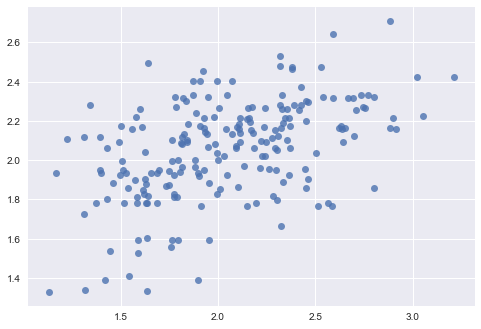

In [54]:
ax = sns.regplot(x = y_test, y = y_rf)
#ax.set(xlim=(0,10000), ylim=(0,10000))

0.15847678571847523

In [56]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

1. feature course_level_partner_Microsoft_Intermediate (0.065823)
2. feature course_partner_MITx (0.043821)
3. feature course_partner_TsinghuaX (0.039218)
4. feature content_language_en-us (0.038218)
5. feature course_partner_BerkeleyX (0.034341)
6. feature course_level_partner_IDBx_Intermediate (0.031608)
7. feature subject_agg_0 (0.028877)
8. feature course_run_number_group_first (0.028695)
9. feature subject_agg_non-STEM (0.025036)
10. feature course_partner_PekingX (0.024657)
11. feature course_run_number_group_re-run (0.024627)
12. feature course_level_partner_PekingX_Introductory (0.024115)
13. feature course_partner_W3Cx (0.022759)
14. feature course_partner_Microsoft (0.019402)
15. feature course_partner_GalileoX (0.018689)
16. feature content_language_zh-cmn (0.016439)
17. feature course_level_partner_UQx_Introductory (0.016003)
18. feature course_partner_AdelaideX (0.015856)
19. feature subject_agg_STEM (0.015288)
20. feature level_type_Intermediate (0.014531)
21. feature cou

In [44]:
course_enroll_filter_df
course_enroll_filter_df.course_run_number = course_enroll_filter_df.course_run_number.astype(str)#.fillna(0.0)
course_enroll_filter_df.enrolls_course_length_norm = course_enroll_filter_df.enrolls_course_length_norm.astype(float)#.fillna(0.0)

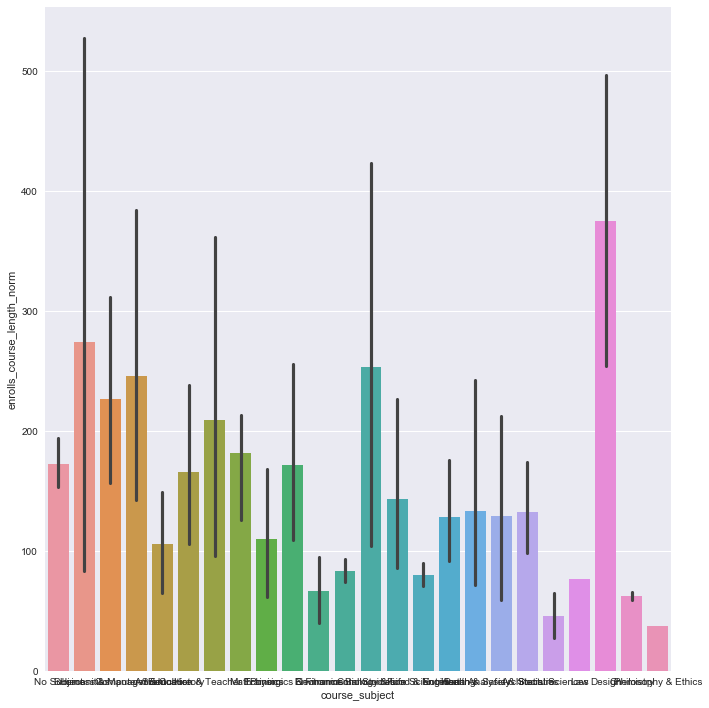

In [58]:
sns.factorplot(
    data = course_enroll_filter_df,
    x = 'course_subject', 
               y = 'enrolls_course_length_norm', 
               kind = 'bar',
size =10)

In [546]:
len(course_enroll_filter_df.enrolls_course_length_norm)

476